In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

In [ ]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Load"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [ ]:
data = []
#for y in range(2017,2023):
for y in [2022]:
  df = pd.read_csv(f"{DATA_DIR}/Load_{y}.csv")
  data.append(df)
data = pd.concat(data)
#print(data.head(20).to_string())

NYC = data['N.Y.C.'];
NYC_slope = data['N.Y.C.']-data['N.Y.C.'].shift(1) 
NYC_slope = NYC_slope.ewm(span = 10).mean()
NYC_slope.fillna(method='bfill',inplace=True)

num_var = 2
print(NYC.head(15));print(len(NYC.index),NYC.mean(),NYC.std())
print(NYC_slope.head(15));print(len(NYC_slope.index),NYC_slope.mean(),NYC_slope.std())


n = len(NYC.index)
t = int(7*24*(60/5))

0     4670.6790
1     4623.9080
2     4642.4116
3     4606.2410
4     4589.0850
5     4574.2725
6     4573.3516
7     4510.8810
8     4510.0913
9     4499.7580
10    4513.1025
11    4497.5947
12    4533.3545
13    4437.2720
14    4402.0660
Name: N.Y.C., dtype: float64
108036 5687.832418083788 1185.1401264331366
0    -46.771000
1    -46.771000
2    -10.869970
3    -21.040655
4    -19.760834
5    -18.340302
6    -13.815882
7    -25.539714
8    -19.908967
9    -17.825637
10   -11.278157
11   -12.142220
12    -2.571484
13   -20.924821
14   -23.687849
Name: N.Y.C., dtype: float64
108036 -0.00047080167369235746 16.789093243410605


In [ ]:
m = 5687.832418083788
std = 1185.1401264331366

m_s = 0 #-3.78815163514314e-05
std_s = 5 #16.78856791915454

m_list = [m,m_s]
std_list = [std,std_s]
def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    dataset=dataset.reshape(s[1],s[0],s[2])
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else:
    dataset=(dataset-mi[0])/stdi[0]
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    dataset=dataset.reshape(s[1],s[0],s[2])
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=2):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[1]-hist_window-forecast_window):
    a = dataset[0:num_var,i:(i+hist_window)]; dataX.append(a)
    dataY.append(dataset[0,i + hist_window:  i + hist_window+forecast_window])
    
  return np.array(dataX), np.array(dataY)

#print(NYC.values);print(NYC_slope.values);print(dataset)
dataset = np.stack([NYC.values,NYC_slope.values])


x,y = create_dataset_mult(dataset,hist_window,forecast_window,num_var)
#print(x)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

#print(train);print(valid)
#print(NYC.head(5))
#print(len(train[0]),train[0]);print(len(label_t[0]),label_t[0])
#print(len(valid[0]),valid[0]);print(len(label_v[0]),label_v[0])

In [ ]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 4)                 368       
                                                                 
 dense_8 (Dense)             (None, 18)                90        
                                                                 
Total params: 458
Trainable params: 458
Non-trainable params: 0
_________________________________________________________________


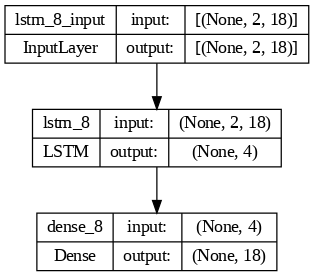

In [ ]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num, hist_window)))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model()
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [ ]:
#Fit Model
model_name = 'test_model_slope.h5'
print(datetime.datetime.now())
#model.fit(train, label_t, epochs=100, batch_size=1, verbose=2)
train_xfr = transform_dataset(train,m_list,std_list)
label_t_xfr = transform_dataset(label_t)
if True:
  model.fit(train_xfr, label_t_xfr, epochs=5, batch_size=1, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-02-01 20:45:40.228904
Epoch 1/5
106020/106020 - 177s - loss: 0.5349 - 177s/epoch - 2ms/step
Epoch 2/5
106020/106020 - 177s - loss: 0.5153 - 177s/epoch - 2ms/step
Epoch 3/5
106020/106020 - 175s - loss: 0.5191 - 175s/epoch - 2ms/step
Epoch 4/5
106020/106020 - 176s - loss: 0.4993 - 176s/epoch - 2ms/step
Epoch 5/5
106020/106020 - 180s - loss: 0.4994 - 180s/epoch - 2ms/step


(106020, 2, 18)
(106020, 18)
62/62 [==============================] - 0s 2ms/step
(1980, 18)
(1980, 18)
Test Score: 2709.31 RMSE
Test Score: 642.63 RMSE


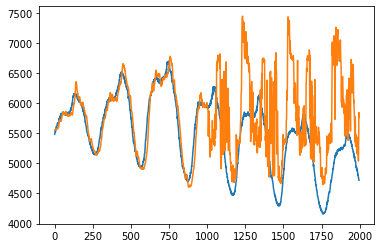

In [ ]:
# make predictions
print(train_xfr.shape)
print(label_t_xfr.shape)
valid_xfr = transform_dataset(valid)
label_p   = untransform_dataset(model.predict(valid_xfr))

## invert predictions
#testPredict = anti_transform(testPredict)   #scaler.inverse_transform(testPredict)
#testY = anti_transform(testY)               #scaler.inverse_transform([testY])
print(label_v.shape)
print(label_p.shape)

# calculate root mean squared error
print('Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))


for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

In [ ]:

# introduced slope variable and did not work well
